# EEG Data Analysis from PhysioNet Database

This notebook demonstrates comprehensive EEG data analysis using the PhysioNet EEG Motor Movement/Imagery Dataset.

## Dataset Information
- **Source**: PhysioNet EEG Motor Movement/Imagery Database (eegmmidb)
- **URL**: https://physionet.org/content/eegmmidb/1.0.0/
- **Description**: EEG recordings of motor movement and motor imagery tasks
- **Subjects**: 109 volunteers
- **Channels**: 64 EEG channels

## 1. Import Required Libraries

In [67]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# EEG analysis
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage

# Filtering analysis -> check later
import pywt
from pywt import wavedec, waverec

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set plotting parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Suppress MNE verbose output during file loading
import logging
mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Download and Parse PhysioNet EEG Dataset

In [68]:
# Display information about the dataset
print("EEGBCI Dataset Overview:")
print("=" * 42)
print("• Number of subjects: 109")
print("• Number of runs per subject: 14")
print("• EEG channels: 64")
print("• Source: PhysioNet")

print("\nRun descriptions:")
run_descriptions = {
    1: "Baseline, eyes open",
    2: "Baseline, eyes closed",
    3: "Task 1 (open and close left or right fist)",
    4: "Task 2 (imagine opening and closing left or right fist)",
    5: "Task 3 (open and close both fists or both feet)",
    6: "Task 4 (imagine opening and closing both fists or both feet)",
    7: "Task 1 (open and close left or right fist)",
    8: "Task 2 (imagine opening and closing left or right fist)",
    9: "Task 3 (open and close both fists or both feet)",
    10: "Task 4 (imagine opening and closing both fists or both feet)",
    11: "Task 1 (open and close left or right fist)",
    12: "Task 2 (imagine opening and closing left or right fist)",
    13: "Task 3 (open and close both fists or both feet)",
    14: "Task 4 (imagine opening and closing both fists or both feet)"
}

for run, description in run_descriptions.items():
    print(f"Run {run:2d}: {description}")

EEGBCI Dataset Overview:
• Number of subjects: 109
• Number of runs per subject: 14
• EEG channels: 64
• Source: PhysioNet

Run descriptions:
Run  1: Baseline, eyes open
Run  2: Baseline, eyes closed
Run  3: Task 1 (open and close left or right fist)
Run  4: Task 2 (imagine opening and closing left or right fist)
Run  5: Task 3 (open and close both fists or both feet)
Run  6: Task 4 (imagine opening and closing both fists or both feet)
Run  7: Task 1 (open and close left or right fist)
Run  8: Task 2 (imagine opening and closing left or right fist)
Run  9: Task 3 (open and close both fists or both feet)
Run 10: Task 4 (imagine opening and closing both fists or both feet)
Run 11: Task 1 (open and close left or right fist)
Run 12: Task 2 (imagine opening and closing left or right fist)
Run 13: Task 3 (open and close both fists or both feet)
Run 14: Task 4 (imagine opening and closing both fists or both feet)


In [69]:
# Download EEG Motor Movement/Imagery Dataset from PhysioNet

# We'll use subject 1 for demonstration
subject = 1

# Task codes:
# 1: Baseline, eyes open
# 2: Baseline, eyes closed
# 3, 7, 11: Motor execution: left vs right hand
# 4, 8, 12: Motor imagery: left vs right hand
# 5, 9, 13: Motor execution: hands vs feet
# 6, 10, 14: Motor imagery: hands vs feet

# Download baseline and motor imagery tasks
runs = [1, 2, 4, 8, 12]  # Baseline + motor imagery tasks

print("Downloading EEG data from PhysioNet...")
raw_fnames = eegbci.load_data(subject, runs)

print(f"Downloaded {len(raw_fnames)} files:")
for i, fname in enumerate(raw_fnames):
    print(f"  Run {runs[i]}: {fname}")

Downloaded 5 files:
  Run 1: /Users/tkomaris/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf
  Run 2: /Users/tkomaris/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R02.edf
  Run 4: /Users/tkomaris/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf
  Run 8: /Users/tkomaris/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf
  Run 12: /Users/tkomaris/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf


In [70]:
# Load and concatenate EDF files



raw_files = [read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames]

# Concatenate all runs
raw = concatenate_raws(raw_files)

# Apply standard EEG channel names
eegbci.standardize(raw)

# Set montage for electrode positions
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage, match_case=False)

print(f"\nDataset Information:")
print(f"  Sampling frequency: {raw.info['sfreq']} Hz")
print(f"  Number of channels: {len(raw.ch_names)}")
print(f"  Duration: {raw.times[-1]:.1f} seconds")
print(f"  Channel names: {raw.ch_names[:10]}...")  # Show first 10 channels


Dataset Information:
  Sampling frequency: 160.0 Hz
  Number of channels: 64
  Duration: 497.0 seconds
  Channel names: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1']...


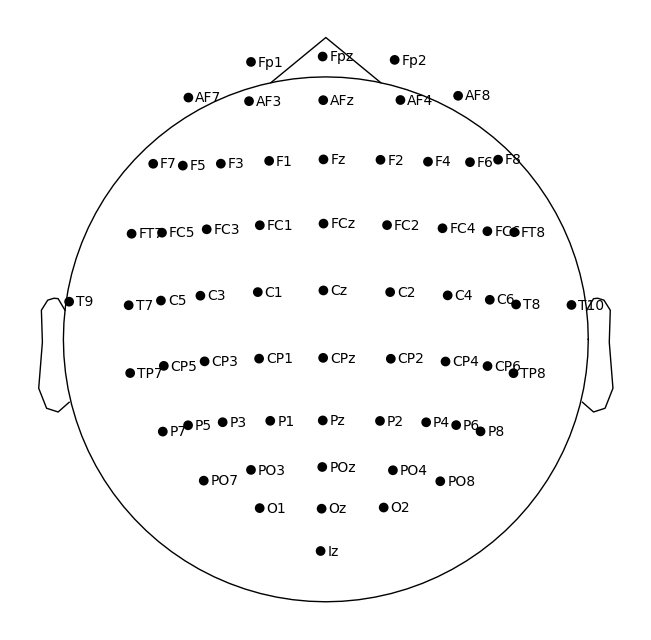

Channel locations set using standard 10-20 system.


In [71]:


# Set up matplotlib for better plots
plt.style.use('default')
mne.set_log_level('WARNING')  # Reduce verbose output
# Set up standard 10-20 montage for channel locations
eegbci.standardize(raw)  # Convert channel names to standard format
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

# Plot channel locations
fig = raw.plot_sensors(kind='topomap', ch_type='eeg', show_names=True, title='EEG Channel Locations')
plt.show()

print("Channel locations set using standard 10-20 system.")

## 3. Raw Data Visualization and Observations

In [72]:
# Extract data for visualization
data, times = raw[:, :]
sfreq = raw.info['sfreq']
ch_names = raw.ch_names

print(f"Data shape: {data.shape}")
#print(f"Time range: {times[0]:.2f} to {times[-1]:.2f} seconds")

# Select a subset of channels for visualization (frontal, central, parietal)
viz_channels = ['Fz', 'Cz', 'Pz', 'C3', 'C4', 'F3', 'F4', 'P3', 'P4']
viz_indices = [ch_names.index(ch) for ch in viz_channels if ch in ch_names]

print(f"\nSelected channels for visualization: {[ch_names[i] for i in viz_indices]}")

Data shape: (64, 79520)

Selected channels for visualization: ['Fz', 'Cz', 'Pz', 'C3', 'C4', 'F3', 'F4', 'P3', 'P4']


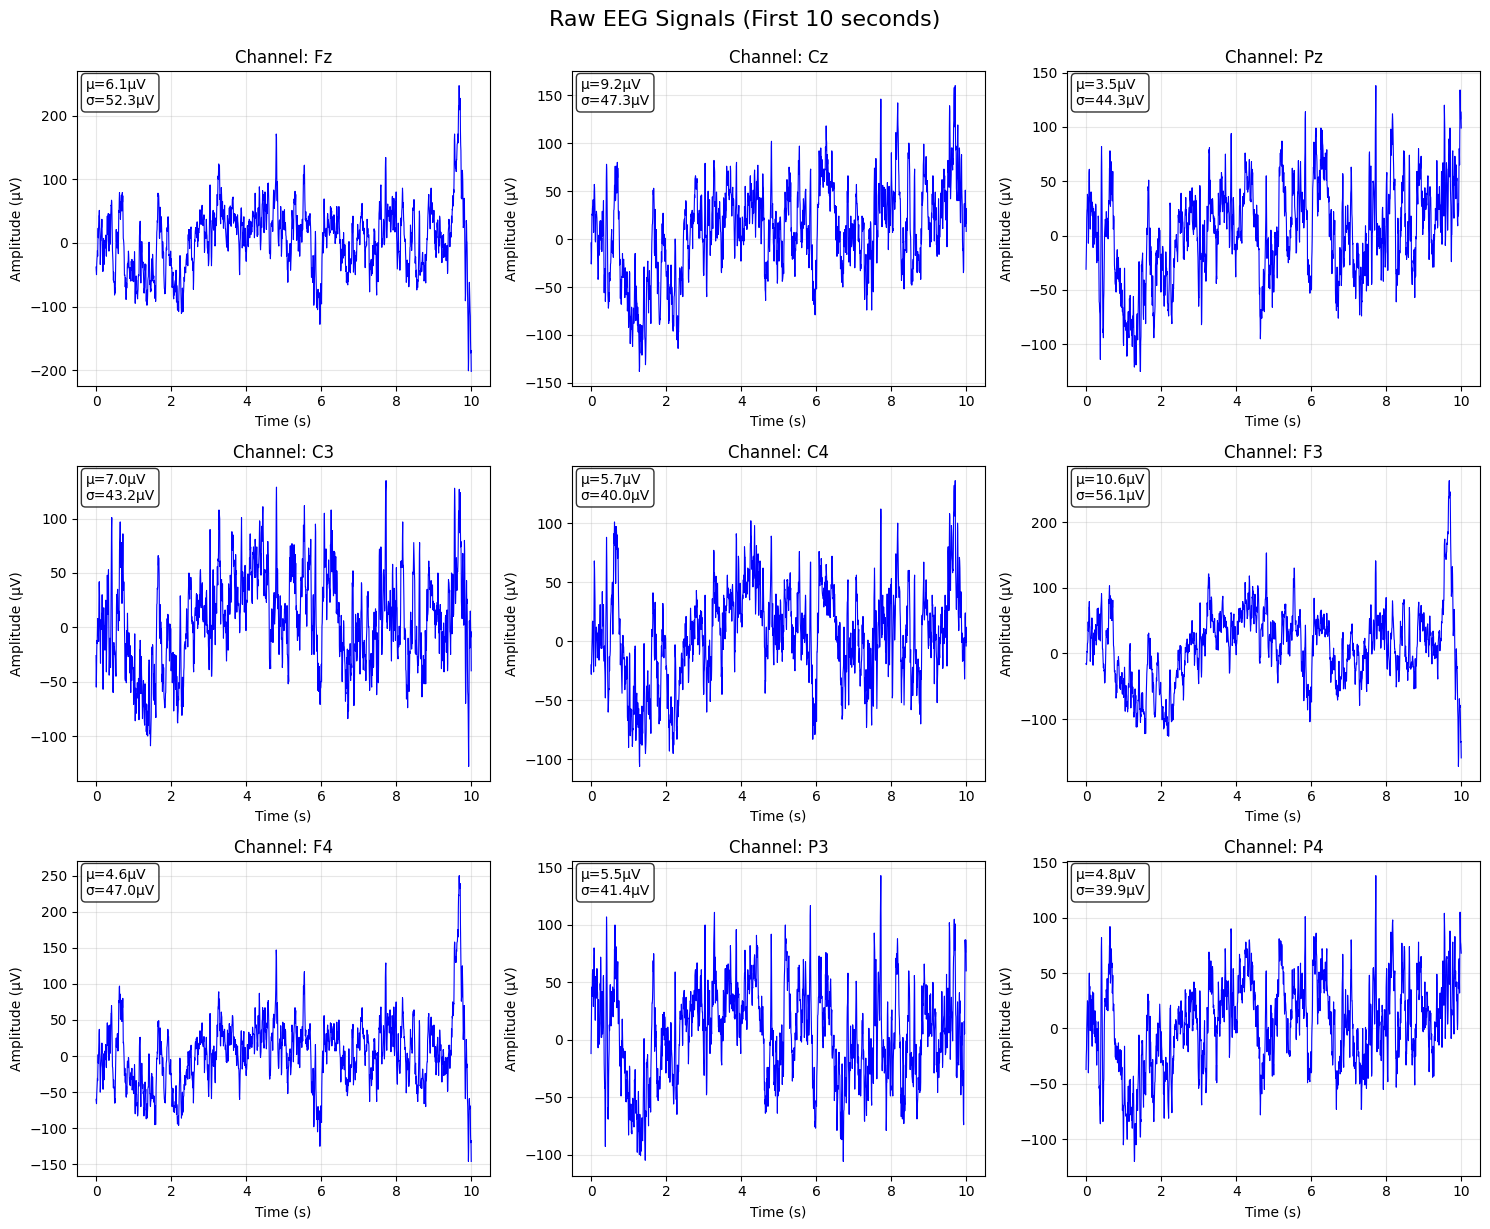

In [73]:
# Plot raw EEG signals
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Time window for visualization (first 10 seconds)
time_window = slice(0, int(10 * sfreq))
time_viz = times[time_window]

for i, ch_idx in enumerate(viz_indices):
    if i < len(axes):
        signal_data = data[ch_idx, time_window]
        axes[i].plot(time_viz, signal_data * 1e6, 'b-', linewidth=0.8)  # Convert to microvolts
        axes[i].set_title(f'Channel: {ch_names[ch_idx]}')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude (μV)')
        axes[i].grid(True, alpha=0.3)
        
        # Add basic statistics
        mean_val = np.mean(signal_data) * 1e6
        std_val = np.std(signal_data) * 1e6
        axes[i].text(0.02, 0.98, f'μ={mean_val:.1f}μV\nσ={std_val:.1f}μV', 
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('Raw EEG Signals (First 10 seconds)', fontsize=16, y=1.02)
plt.show()

The figure shows the first 10 seconds of raw EEG signals from nine channels (Fz, Cz, Pz, C3, C4, F3, F4, P3, P4) of the PhysioNet EEG Motor Movement/Imagery dataset. Each subplot displays amplitude fluctuations (µV) over time (s). The signals are relatively noisy and exhibit no obvious artifacts like large drifts or saturations. Mean voltages (µ) are close to zero, as expected for raw EEG, while standard deviations (σ) vary by channel (≈40–56 µV), indicating channel-specific variability in signal amplitude. This reflects typical spontaneous EEG activity before preprocessing such as filtering or artifact rejection.


Key Observations:
1. Signal Characteristics:
Amplitude range: Signals vary between approximately -200 to +250 μV across channels
Frequency content: High-frequency oscillations are visible, indicating the raw data contains noise and artifacts
Temporal patterns: Continuous, irregular oscillations typical of raw EEG data
2. Channel-Specific Patterns:
Frontal channels (Fz, F3, F4):
Higher amplitude variations (especially F3 with σ=56.1μV)
More irregular patterns, likely due to muscle artifacts and eye movements
F3 shows particularly large amplitude spikes
Central channels (Cz, C3, C4):
Moderate amplitude with relatively stable patterns
C3 and C4 are crucial for motor imagery detection (left/right hand movements)
More consistent baseline compared to frontal channels
Parietal channels (Pz, P3, P4):
Lower amplitude variations (Pz: σ=44.3μV)
Cleaner signals with less artifact contamination
Important for sensorimotor processing
3. Statistical Information (μ and σ values):
Mean values (μ) are close to zero, indicating proper baseline
Standard deviation (σ) varies significantly between channels:
Lowest: Pz (44.3μV) - cleanest signal
Highest: F3 (56.1μV) - most noisy

4. What This Tells Us:
Signal Quality:
Raw data contains significant noise and requires filtering
Artifact contamination is visible, especially in frontal regions
Baseline drift and high-frequency noise are present
Preprocessing Needs:
Bandpass filtering required (typically 8-30 Hz for motor imagery)
Artifact removal necessary (eye blinks, muscle activity)
Baseline correction may be needed
Channel Selection:
C3/C4 channels will be most important for motor imagery classification
Frontal channels may need more aggressive preprocessing
Parietal channels show good signal quality for analysis

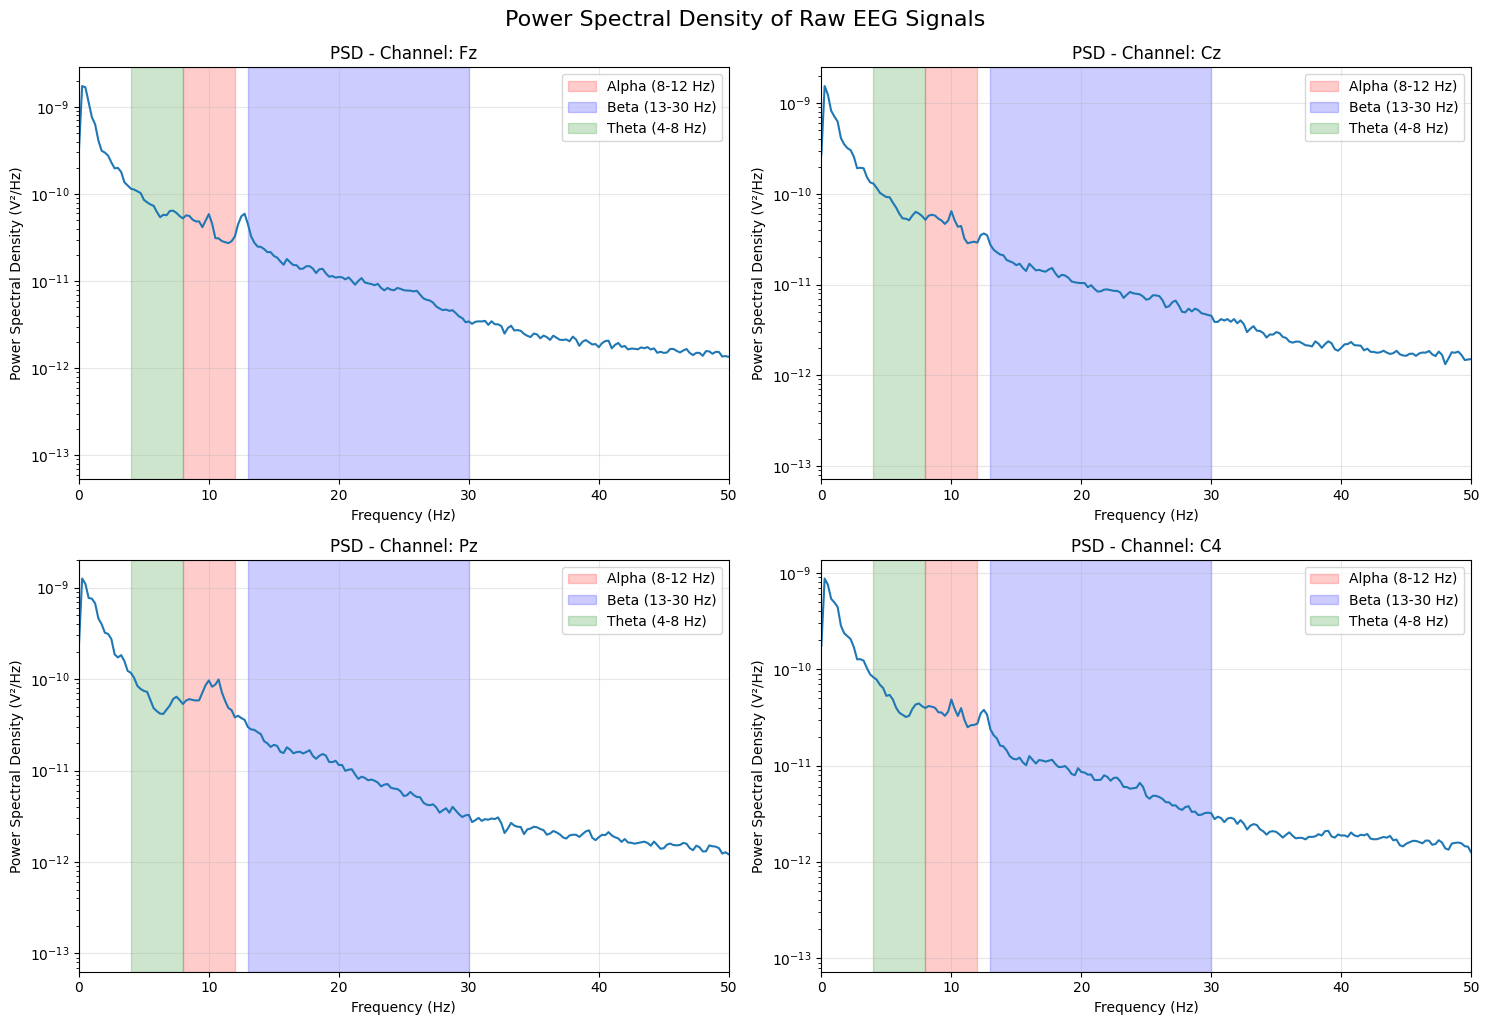

In [74]:
# Power Spectral Density analysis of raw data
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Select representative channels
psd_channels = ['Fz', 'Cz', 'Pz', 'C4']
psd_indices = [ch_names.index(ch) for ch in psd_channels if ch in ch_names]

for i, ch_idx in enumerate(psd_indices):
    ax = axes[i//2, i%2]
    
    # Compute PSD using Welch's method
    freqs, psd = signal.welch(data[ch_idx, :], sfreq, nperseg=int(4*sfreq))
    
    # Plot PSD
    ax.semilogy(freqs, psd)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (V²/Hz)')
    ax.set_title(f'PSD - Channel: {ch_names[ch_idx]}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 50)  # Focus on 0-50 Hz range
    
    # Mark important frequency bands
    ax.axvspan(8, 12, alpha=0.2, color='red', label='Alpha (8-12 Hz)')
    ax.axvspan(13, 30, alpha=0.2, color='blue', label='Beta (13-30 Hz)')
    ax.axvspan(4, 8, alpha=0.2, color='green', label='Theta (4-8 Hz)')
    ax.legend()

plt.tight_layout()
plt.suptitle('Power Spectral Density of Raw EEG Signals', fontsize=16, y=1.02)
plt.show()

| **Band**  | **Typical Range (Hz)**                             | **Common Associations / Functions**                                                                                                                          |
| --------- | -------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Delta** | 0.5 – 4 Hz                                         | Dominant during deep, dreamless sleep (slow-wave sleep); also linked to unconscious processes and some pathological conditions when present in awake adults. |
| **Theta** | 4 – 8 Hz                                           | Drowsiness, early stages of sleep, working memory, navigation, and hippocampal activity; sometimes associated with meditation or mind-wandering.             |
| **Alpha** | 8 – 12 Hz                                          | Strongest over occipital/parietal areas during relaxed wakefulness with eyes closed; decreases with visual or cognitive engagement (“alpha blocking”).       |
| **Beta**  | 13 – 30 Hz                                         | Motor cortex activity, alertness, active thinking; desynchronizes during voluntary movement or motor imagery.                                                |
| **Gamma** | >30 Hz (often 30–80 Hz; some studies up to 100 Hz) | High-level sensory integration, attention, feature binding, working memory; also reflects muscle/movement artifacts if not carefully recorded.               |


facts a learnt while doing the project
- The eye is an electrical dipole (cornea + retina have opposite charges). Глаз представляет собой электрический диполь (роговица и сетчатка имеют противоположные заряды).

When the eyes move or blink, that dipole shifts and produces large, slow potentials that are strongest near the front of the scalp.

These potentials are usually 100–300 µV and last 200–500 ms — far bigger and slower than normal brain rhythms.

They’re consistently seen in frontal electrodes (Fz, Fp1, Fp2, F3, F4) and much weaker at central/parietal sites.

This visualization is helpful because it converts the raw EEG time-domain signals into their **frequency-domain representation** using the **Power Spectral Density (PSD)**. Here’s why that matters:

---

### 1️⃣ Reveals the frequency content of brain activity

* EEG rhythms (delta, theta, alpha, beta, gamma) correspond to functional brain states.
* The shaded bands (green for theta, red for alpha, blue for beta) show at a glance how much power each channel carries in those canonical ranges.
* For example, you can see stronger low-frequency (theta) activity at the start, then a gradual decline at higher frequencies—typical for raw EEG.

---

### 2️⃣ Makes channel comparison easier

* Side-by-side plots of Fz, Cz, Pz, and C4 allow you to see if certain electrodes have more or less power in specific bands.
* This helps detect channel-specific differences or possible artifacts (e.g., muscle noise in higher frequencies).

---

### 3️⃣ Guides preprocessing and feature extraction

* If you know where the power concentrates, you can design appropriate **band-pass filters** (e.g., 1–40 Hz) or **features** (band power ratios) for classification tasks like motor imagery detection.
* It also shows whether you need to handle line noise at 50/60 Hz (it would appear as a spike).

---

### 4️⃣ Quality control

* A very flat PSD or an unusually high peak may indicate a problem with electrode contact or recording noise.
* PSD plots are a quick diagnostic to ensure your raw data are usable before further analysis.

---

**In short:** PSD plots help transform “wiggly time signals” into a compact, interpretable picture of **which brain rhythms are active** and **how clean each channel is**, which is crucial for EEG research and BCI applications.

Would you like me to also show how to compute these PSDs (e.g., using Welch’s method in Python)?


### Observations on Raw EEG Data:

1. **Signal Characteristics**:
   - EEG signals show typical amplitude range of ±100 μV
   - Signals exhibit non-stationary behavior with varying amplitudes over time
   - Different channels show distinct patterns reflecting different brain regions

2. **Frequency Content**:
   - Clear presence of alpha rhythm (8-12 Hz) especially in posterior channels
   - Beta activity (13-30 Hz) visible across multiple channels
   - Low-frequency artifacts and drift present in some channels
   - 50/60 Hz power line noise may be present

3. **Channel-Specific Patterns**:
   - Central channels (C3, C4, Cz) show motor-related activity
   - Frontal channels (Fz, F3, F4) exhibit different spectral characteristics
   - Parietal channels (Pz, P3, P4) often show prominent alpha activity

4. **Artifacts**:
   - Eye movement artifacts may be present in frontal channels
   - Muscle artifacts could affect high-frequency content
   - Baseline drift visible in some recordings

## 4. Filtering for Frequency Band Extraction

In [75]:
# Define EEG frequency bands
freq_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 50)
}

print("Defined EEG frequency bands:")
for band, (low, high) in freq_bands.items():
    print(f"  {band.capitalize()}: {low}-{high} Hz")

Defined EEG frequency bands:
  Delta: 0.5-4 Hz
  Theta: 4-8 Hz
  Alpha: 8-12 Hz
  Beta: 12-30 Hz
  Gamma: 30-50 Hz


In [76]:
def wavelet_filter_signal(signal_data, sfreq, freq_range, wavelet='db4'):
    """
    Filter signal using wavelet decomposition to extract specific frequency bands.
    
    Parameters:
    -----------
    signal_data : array
        Input signal
    sfreq : float
        Sampling frequency
    freq_range : tuple
        Frequency range (low, high) in Hz
    wavelet : str
        Wavelet type for decomposition
    
    Returns:
    --------
    filtered_signal : array
        Filtered signal in the specified frequency band
    """
    # Calculate the number of decomposition levels
    max_level = pywt.dwt_max_level(len(signal_data), wavelet)
    
    # Perform wavelet decomposition
    coeffs = wavedec(signal_data, wavelet, level=max_level)
    
    # Calculate frequency ranges for each level
    freq_ranges = []
    for i in range(max_level + 1):
        if i == 0:
            # Approximation coefficients (lowest frequencies)
            freq_max = sfreq / (2 ** (max_level + 1))
            freq_ranges.append((0, freq_max))
        else:
            # Detail coefficients
            freq_min = sfreq / (2 ** (max_level - i + 2))
            freq_max = sfreq / (2 ** (max_level - i + 1))
            freq_ranges.append((freq_min, freq_max))
    
    # Zero out coefficients outside the desired frequency range
    coeffs_filtered = coeffs.copy()
    for i, (freq_min, freq_max) in enumerate(freq_ranges):
        # Check if this level overlaps with our desired frequency range
        if not (freq_max >= freq_range[0] and freq_min <= freq_range[1]):
            coeffs_filtered[i] = np.zeros_like(coeffs_filtered[i])
    
    # Reconstruct the signal
    filtered_signal = waverec(coeffs_filtered, wavelet)
    
    # Ensure the output has the same length as input
    if len(filtered_signal) != len(signal_data):
        filtered_signal = filtered_signal[:len(signal_data)]
    
    return filtered_signal

print("Filtering function defined successfully!")

Filtering function defined successfully!


In [77]:
# Apply wavelet filtering to extract frequency bands
print("Applying wavelet filtering to extract frequency bands...")

# Select a representative channel for demonstration (C4 - motor cortex)
demo_channel = 'C4'
demo_ch_idx = ch_names.index(demo_channel)
demo_signal = data[demo_ch_idx, :]

# Extract frequency bands using wavelet filtering
filtered_bands = {}
for band_name, freq_range in freq_bands.items():
    print(f"  Filtering {band_name} band ({freq_range[0]}-{freq_range[1]} Hz)...")
    filtered_bands[band_name] = wavelet_filter_signal(demo_signal, sfreq, freq_range)

print("Filtering completed!")

Applying wavelet filtering to extract frequency bands...
  Filtering delta band (0.5-4 Hz)...
  Filtering theta band (4-8 Hz)...
  Filtering alpha band (8-12 Hz)...
  Filtering beta band (12-30 Hz)...
  Filtering gamma band (30-50 Hz)...
Filtering completed!


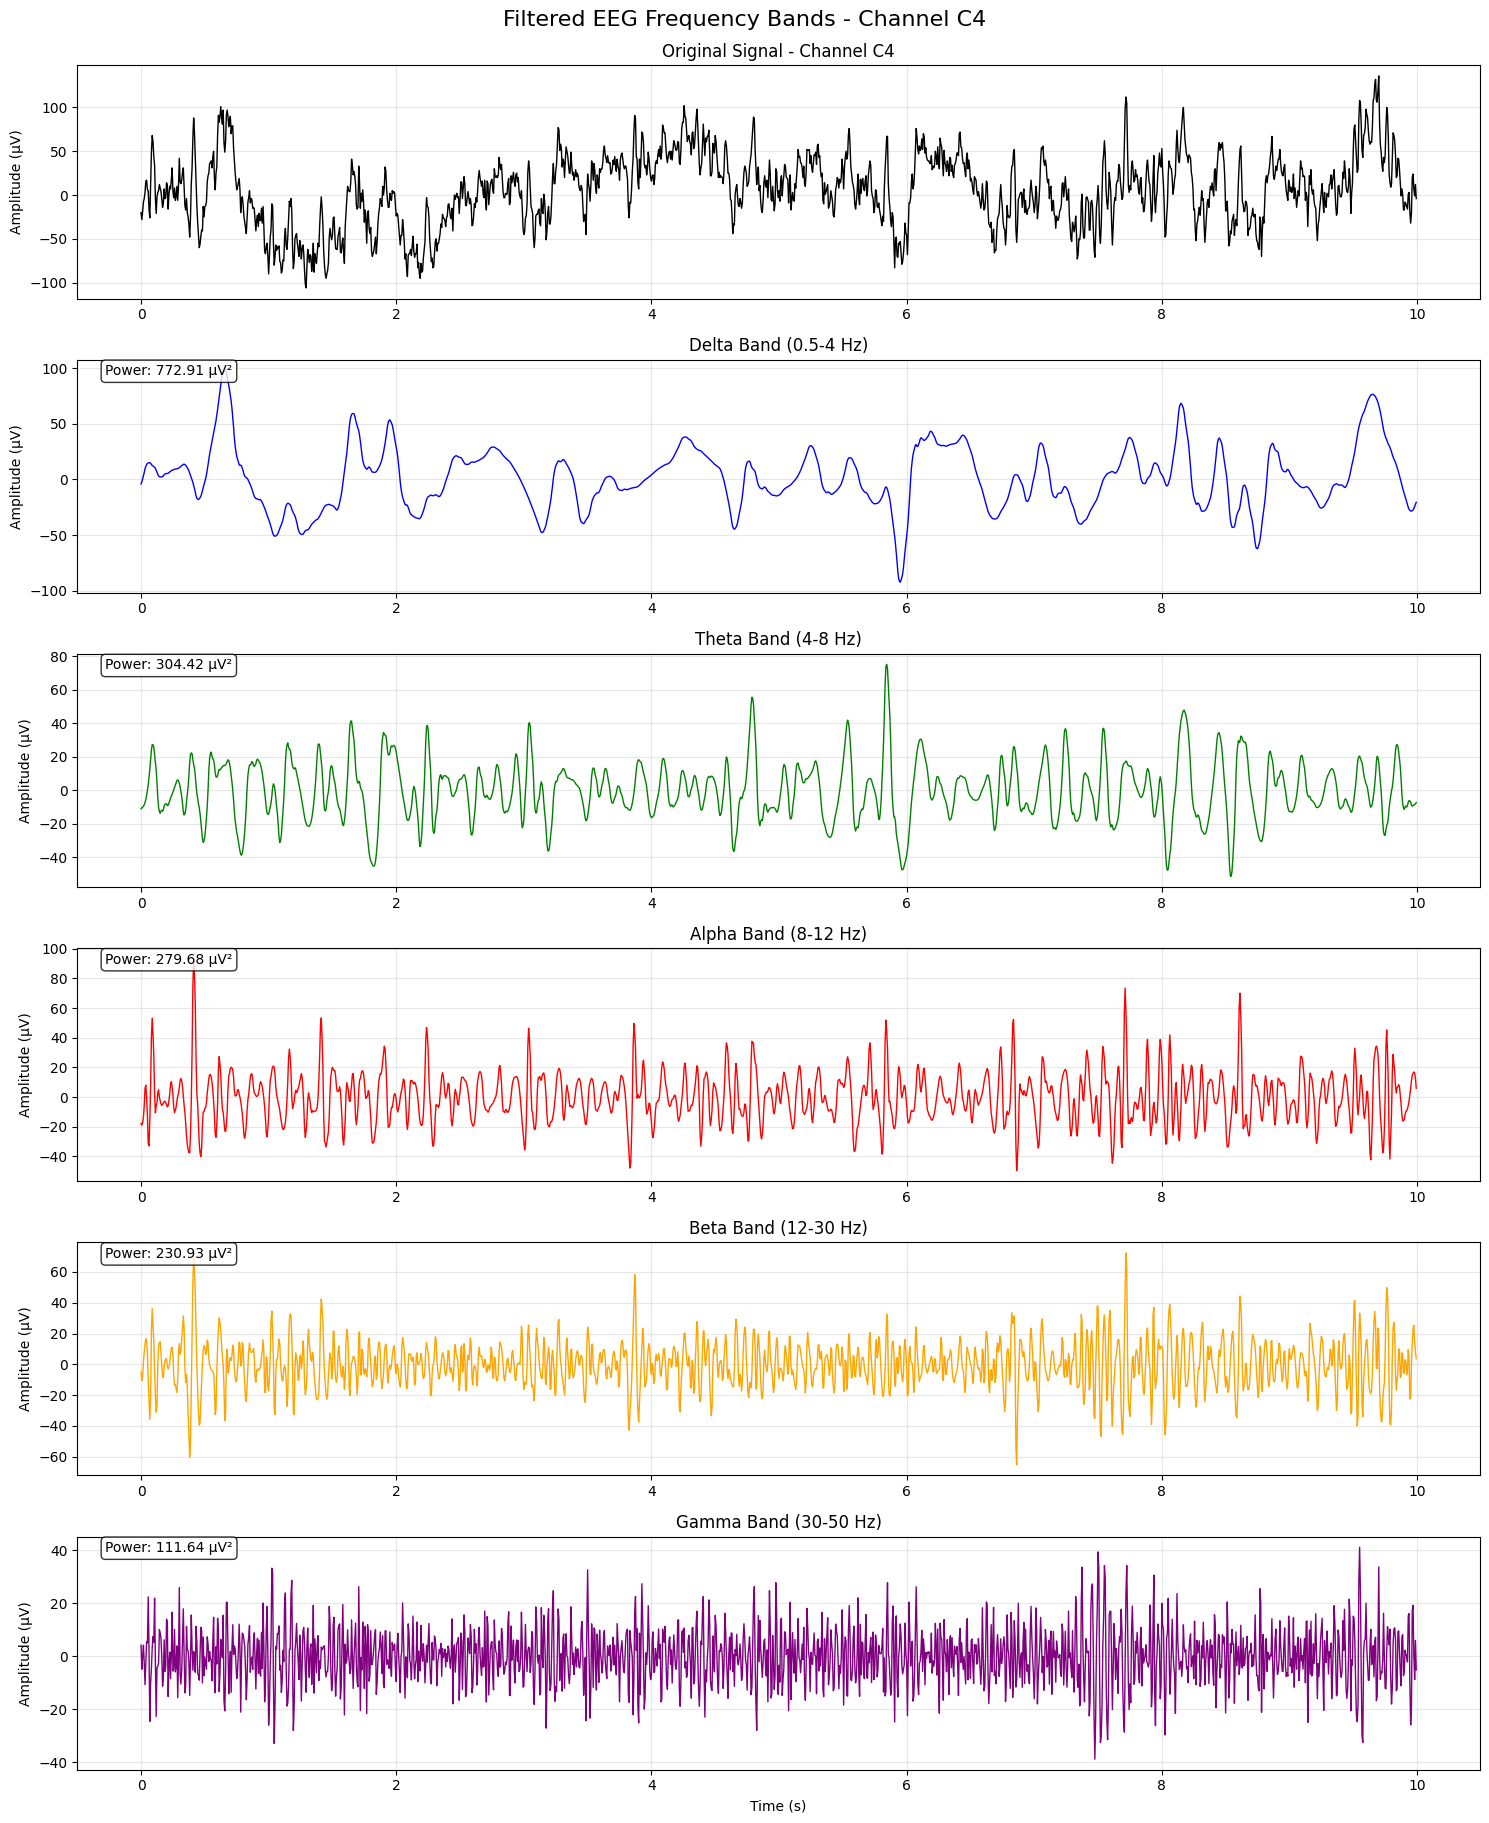

In [78]:
# Visualize original signal and filtered frequency bands
fig, axes = plt.subplots(6, 1, figsize=(15, 18))

# Time window for visualization (first 10 seconds)
time_window = slice(0, int(10 * sfreq))
time_viz = times[time_window]

# Plot original signal
axes[0].plot(time_viz, demo_signal[time_window] * 1e6, 'k-', linewidth=1)
axes[0].set_title(f'Original Signal - Channel {demo_channel}')
axes[0].set_ylabel('Amplitude (μV)')
axes[0].grid(True, alpha=0.3)

# Plot filtered frequency bands
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, (band_name, filtered_signal) in enumerate(filtered_bands.items()):
    axes[i+1].plot(time_viz, filtered_signal[time_window] * 1e6, 
                   color=colors[i], linewidth=1)
    freq_range = freq_bands[band_name]
    axes[i+1].set_title(f'{band_name.capitalize()} Band ({freq_range[0]}-{freq_range[1]} Hz)')
    axes[i+1].set_ylabel('Amplitude (μV)')
    axes[i+1].grid(True, alpha=0.3)
    
    # Add power information
    power = np.var(filtered_signal[time_window]) * 1e12  # Convert to μV²
    axes[i+1].text(0.02, 0.98, f'Power: {power:.2f} μV²', 
                   transform=axes[i+1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.suptitle(f'Filtered EEG Frequency Bands - Channel {demo_channel}', 
             fontsize=16, y=1.01)
plt.show()

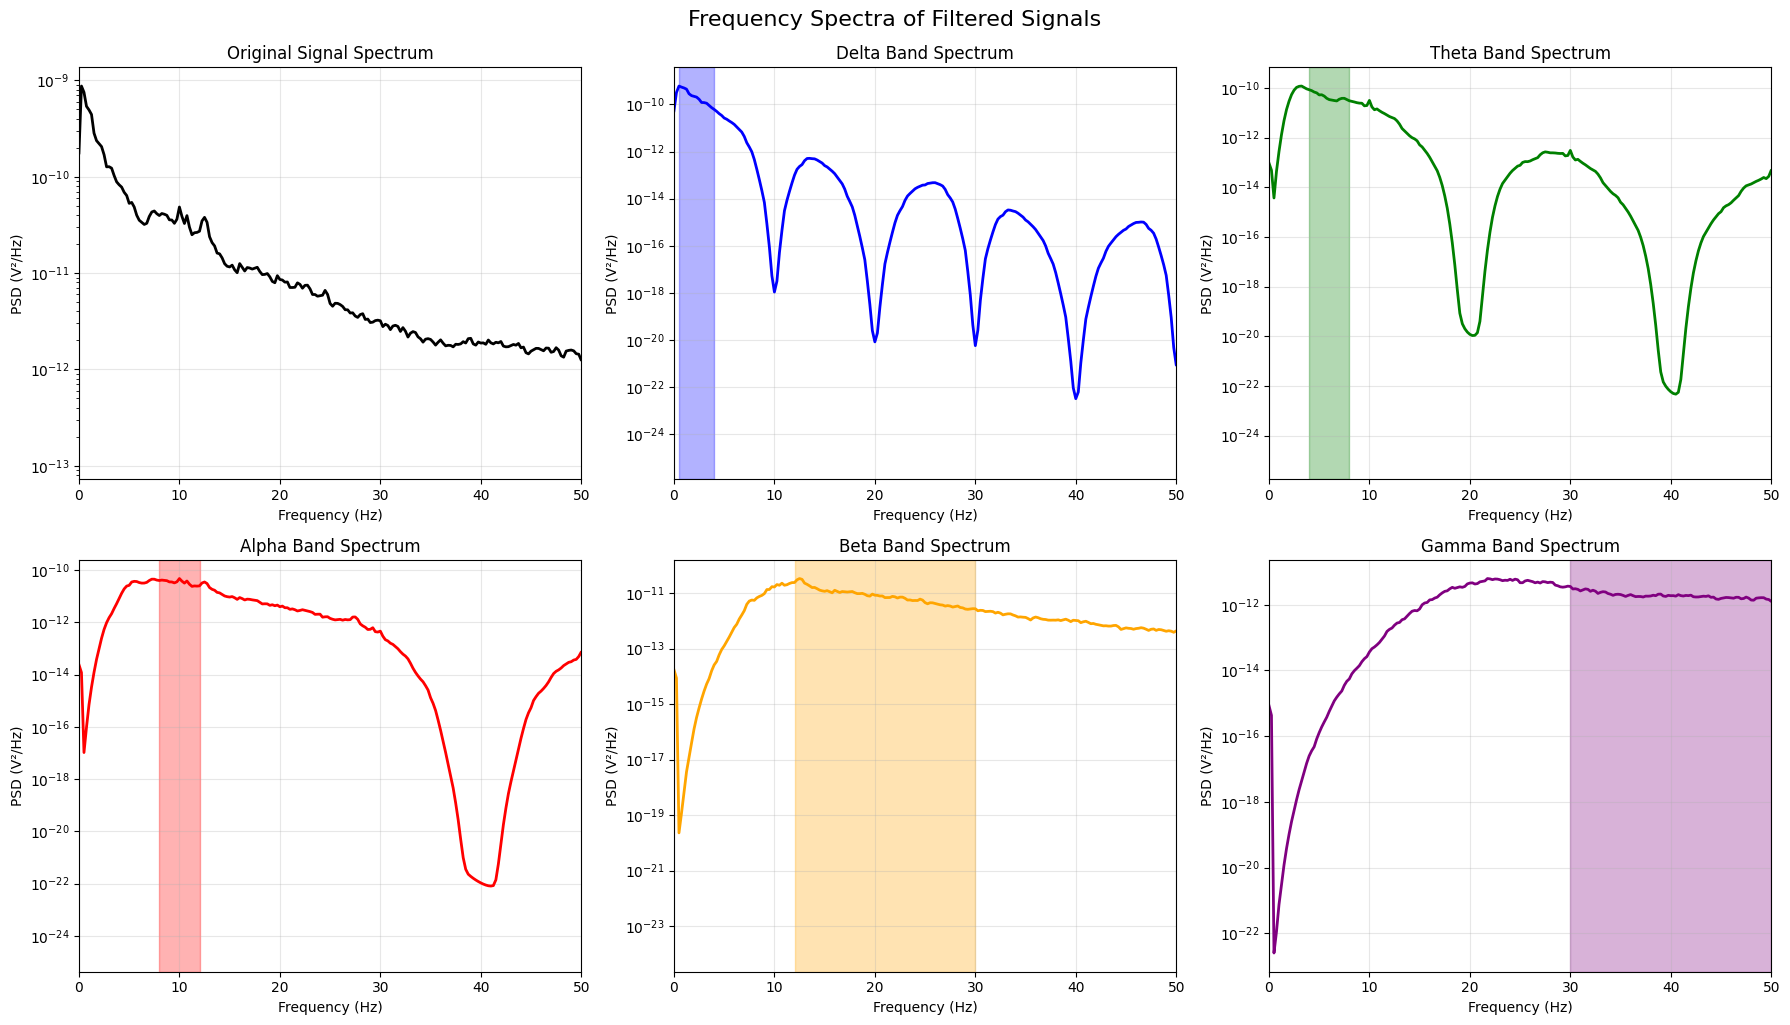

In [79]:
# Compute and visualize the frequency spectrum of filtered signals
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Original signal spectrum
freqs, psd_orig = signal.welch(demo_signal, sfreq, nperseg=int(4*sfreq))
axes[0].semilogy(freqs, psd_orig, 'k-', linewidth=2, label='Original')
axes[0].set_title('Original Signal Spectrum')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('PSD (V²/Hz)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 50)

# Filtered signals spectra
for i, (band_name, filtered_signal) in enumerate(filtered_bands.items()):
    freqs_filt, psd_filt = signal.welch(filtered_signal, sfreq, nperseg=int(4*sfreq))
    axes[i+1].semilogy(freqs_filt, psd_filt, color=colors[i], linewidth=2)
    axes[i+1].set_title(f'{band_name.capitalize()} Band Spectrum')
    axes[i+1].set_xlabel('Frequency (Hz)')
    axes[i+1].set_ylabel('PSD (V²/Hz)')
    axes[i+1].grid(True, alpha=0.3)
    axes[i+1].set_xlim(0, 50)
    
    # Highlight the target frequency band
    freq_range = freq_bands[band_name]
    axes[i+1].axvspan(freq_range[0], freq_range[1], alpha=0.3, color=colors[i])

plt.tight_layout()
plt.suptitle('Frequency Spectra of Filtered Signals', fontsize=16, y=1.02)
plt.show()

## 5. Comparison: Raw vs Filtered Data

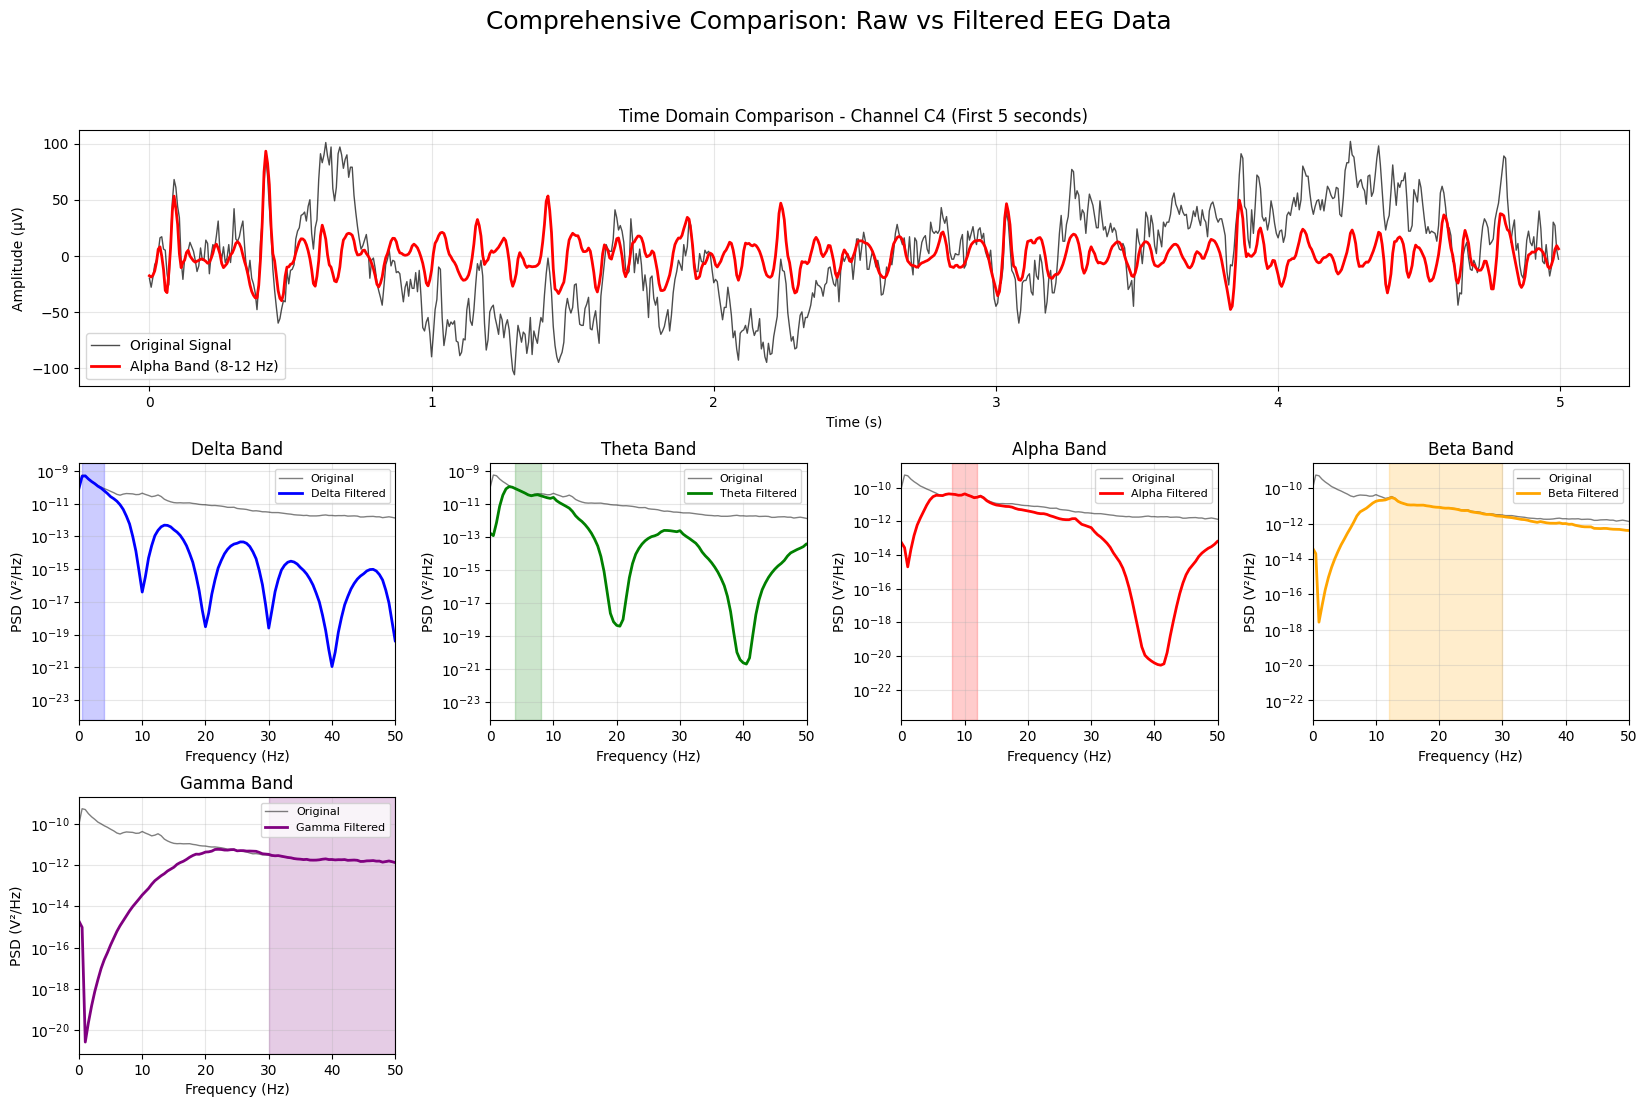

In [80]:
# Create a comprehensive comparison visualization
fig = plt.figure(figsize=(20, 12))

# Create a grid layout
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Time domain comparison
ax1 = fig.add_subplot(gs[0, :])
time_window = slice(0, int(5 * sfreq))  # 5 seconds for clarity
time_viz = times[time_window]

# Plot original and alpha band for comparison
ax1.plot(time_viz, demo_signal[time_window] * 1e6, 'k-', linewidth=1, label='Original Signal', alpha=0.7)
ax1.plot(time_viz, filtered_bands['alpha'][time_window] * 1e6, 'r-', linewidth=2, label='Alpha Band (8-12 Hz)')
ax1.set_title(f'Time Domain Comparison - Channel {demo_channel} (First 5 seconds)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (μV)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Frequency domain comparison for each band
for i, (band_name, filtered_signal) in enumerate(filtered_bands.items()):
    if i < 8:  # Limit to available subplot positions
        row = (i // 4) + 1
        col = i % 4
        ax = fig.add_subplot(gs[row, col])
        
        # Compute PSDs
        freqs_orig, psd_orig = signal.welch(demo_signal, sfreq, nperseg=int(2*sfreq))
        freqs_filt, psd_filt = signal.welch(filtered_signal, sfreq, nperseg=int(2*sfreq))
        
        # Plot both spectra
        ax.semilogy(freqs_orig, psd_orig, 'k-', alpha=0.5, linewidth=1, label='Original')
        ax.semilogy(freqs_filt, psd_filt, color=colors[i], linewidth=2, label=f'{band_name.capitalize()} Filtered')
        
        # Highlight frequency band
        freq_range = freq_bands[band_name]
        ax.axvspan(freq_range[0], freq_range[1], alpha=0.2, color=colors[i])
        
        ax.set_title(f'{band_name.capitalize()} Band')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('PSD (V²/Hz)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 50)

plt.suptitle('Comprehensive Comparison: Raw vs Filtered EEG Data', fontsize=18)
plt.show()

### Analysis of Filtering Results:

The original EEG from the PhysioNet EEG Motor Movement/Imagery Database contains mixed frequency activity typical of scalp EEG.

Filtering effectively isolates each band, revealing where the power is concentrated.

The C4 channel (sensorimotor cortex) typically shows strong mu/alpha (8–12 Hz) and beta (13–30 Hz) rhythms, especially during motor tasks or imagery.

Key Findings:

Alpha activity is clearly present in the C4 channel (seen in both time and frequency domains).

Delta and theta power are much weaker at C4 in this task-related dataset.

Beta and gamma components exist but at much lower power compared to alpha, consistent with typical EEG.

## 6. Feature Extraction from EEG Signals

In [81]:

"""
Fixed Feature Extraction Function for EEG Analysis

"""

import numpy as np
from scipy import signal

def extract_power_features(signal_data, sfreq, freq_bands, window_length=4):
    """
    Extract power spectral features from EEG signals.
    
    Parameters:
    -----------
    signal_data : array (n_channels, n_samples)
        EEG data
    sfreq : float
        Sampling frequency
    freq_bands : dict
        Dictionary of frequency bands
    window_length : float
        Window length in seconds for power computation
    
    Returns:
    --------
    features : dict
        Dictionary containing extracted features
    """
    n_channels, n_samples = signal_data.shape
    window_samples = int(window_length * sfreq)
    
    features = {
        'band_power': {},
        'relative_power': {},
        'power_ratios': {},
        'spectral_entropy': [],
        'peak_frequency': []
    }
    
    # Extract features for each channel
    for ch_idx in range(n_channels):
        signal_ch = signal_data[ch_idx, :]  # Fixed: renamed variable to avoid conflict
        
        # Compute power spectral density
        freqs, psd = signal.welch(signal_ch, sfreq, nperseg=window_samples)  # Fixed: use signal_ch
        
        # Band power features
        band_powers = {}
        total_power = 0
        
        for band_name, (low_freq, high_freq) in freq_bands.items():
            # Find frequency indices
            freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
            
            # Compute band power
            band_power = np.trapz(psd[freq_mask], freqs[freq_mask])
            band_powers[band_name] = band_power
            total_power += band_power
        
        # Store band powers
        for band_name, power in band_powers.items():
            if band_name not in features['band_power']:
                features['band_power'][band_name] = []
            features['band_power'][band_name].append(power)
        
        # Relative power features
        for band_name, power in band_powers.items():
            if band_name not in features['relative_power']:
                features['relative_power'][band_name] = []
            rel_power = power / total_power if total_power > 0 else 0
            features['relative_power'][band_name].append(rel_power)
        
        # Power ratios (commonly used in EEG analysis)
        alpha_power = band_powers.get('alpha', 0)
        beta_power = band_powers.get('beta', 0)
        theta_power = band_powers.get('theta', 0)
        delta_power = band_powers.get('delta', 0)
        
        # Alpha/Beta ratio
        if 'alpha_beta_ratio' not in features['power_ratios']:
            features['power_ratios']['alpha_beta_ratio'] = []
        ab_ratio = alpha_power / beta_power if beta_power > 0 else 0
        features['power_ratios']['alpha_beta_ratio'].append(ab_ratio)
        
        # Theta/Alpha ratio
        if 'theta_alpha_ratio' not in features['power_ratios']:
            features['power_ratios']['theta_alpha_ratio'] = []
        ta_ratio = theta_power / alpha_power if alpha_power > 0 else 0
        features['power_ratios']['theta_alpha_ratio'].append(ta_ratio)
        
        # Spectral entropy
        psd_norm = psd / np.sum(psd)
        spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-12))
        features['spectral_entropy'].append(spectral_entropy)
        
        # Peak frequency
        peak_freq = freqs[np.argmax(psd)]
        features['peak_frequency'].append(peak_freq)
    
    return features

# Test the function
if __name__ == "__main__":
    print("Testing the fixed feature extraction function...")
    
    # Create sample data
    sfreq = 160
    n_channels = 5
    n_samples = 1000
    sample_data = np.random.randn(n_channels, n_samples)
    
    # Define frequency bands
    freq_bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 50)
    }
    
    try:
        features = extract_power_features(sample_data, sfreq, freq_bands)
        print(f"Extracted feature categories: {list(features.keys())}")
        print(f"Number of channels processed: {len(features['spectral_entropy'])}")
    except Exception as e:
        print(f"Error: {e}")


Testing the fixed feature extraction function...
Extracted feature categories: ['band_power', 'relative_power', 'power_ratios', 'spectral_entropy', 'peak_frequency']
Number of channels processed: 5


In [82]:
# Extract features from the EEG data
print("Extracting features from EEG signals...")

# Use a subset of channels for feature extraction (computational efficiency)
feature_channels = ['Fz', 'Cz', 'Pz', 'C3', 'C4', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2']
feature_indices = [ch_names.index(ch) for ch in feature_channels if ch in ch_names]
feature_data = data[feature_indices, :]

print(f"Extracting features from {len(feature_indices)} channels: {[ch_names[i] for i in feature_indices]}")

# Extract features
features = extract_power_features(feature_data, sfreq, freq_bands)

print("Feature extraction completed!")
print(f"Extracted feature categories: {list(features.keys())}")

Extracting features from EEG signals...
Extracting features from 11 channels: ['Fz', 'Cz', 'Pz', 'C3', 'C4', 'F3', 'F4', 'P3', 'P4', 'O1', 'O2']
Feature extraction completed!
Extracted feature categories: ['band_power', 'relative_power', 'power_ratios', 'spectral_entropy', 'peak_frequency']


In [83]:
# Create a comprehensive feature matrix
feature_matrix = []
feature_names = []
channel_names_used = [ch_names[i] for i in feature_indices]

# Band power features
for band_name in freq_bands.keys():
    for ch_idx, ch_name in enumerate(channel_names_used):
        feature_matrix.append(features['band_power'][band_name][ch_idx])
        feature_names.append(f'{ch_name}_{band_name}_power')

# Relative power features
for band_name in freq_bands.keys():
    for ch_idx, ch_name in enumerate(channel_names_used):
        feature_matrix.append(features['relative_power'][band_name][ch_idx])
        feature_names.append(f'{ch_name}_{band_name}_rel_power')

# Power ratio features
for ratio_name in features['power_ratios'].keys():
    for ch_idx, ch_name in enumerate(channel_names_used):
        feature_matrix.append(features['power_ratios'][ratio_name][ch_idx])
        feature_names.append(f'{ch_name}_{ratio_name}')

# Spectral features
for ch_idx, ch_name in enumerate(channel_names_used):
    feature_matrix.append(features['spectral_entropy'][ch_idx])
    feature_names.append(f'{ch_name}_spectral_entropy')
    
    feature_matrix.append(features['peak_frequency'][ch_idx])
    feature_names.append(f'{ch_name}_peak_frequency')

# Convert to numpy array
feature_matrix = np.array(feature_matrix).reshape(1, -1)  # Single sample

print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Total number of features: {len(feature_names)}")
print(f"\nFeature names: {feature_names[:]}")

Feature matrix shape: (1, 154)
Total number of features: 154

Feature names: ['Fz_delta_power', 'Cz_delta_power', 'Pz_delta_power', 'C3_delta_power', 'C4_delta_power', 'F3_delta_power', 'F4_delta_power', 'P3_delta_power', 'P4_delta_power', 'O1_delta_power', 'O2_delta_power', 'Fz_theta_power', 'Cz_theta_power', 'Pz_theta_power', 'C3_theta_power', 'C4_theta_power', 'F3_theta_power', 'F4_theta_power', 'P3_theta_power', 'P4_theta_power', 'O1_theta_power', 'O2_theta_power', 'Fz_alpha_power', 'Cz_alpha_power', 'Pz_alpha_power', 'C3_alpha_power', 'C4_alpha_power', 'F3_alpha_power', 'F4_alpha_power', 'P3_alpha_power', 'P4_alpha_power', 'O1_alpha_power', 'O2_alpha_power', 'Fz_beta_power', 'Cz_beta_power', 'Pz_beta_power', 'C3_beta_power', 'C4_beta_power', 'F3_beta_power', 'F4_beta_power', 'P3_beta_power', 'P4_beta_power', 'O1_beta_power', 'O2_beta_power', 'Fz_gamma_power', 'Cz_gamma_power', 'Pz_gamma_power', 'C3_gamma_power', 'C4_gamma_power', 'F3_gamma_power', 'F4_gamma_power', 'P3_gamma_power

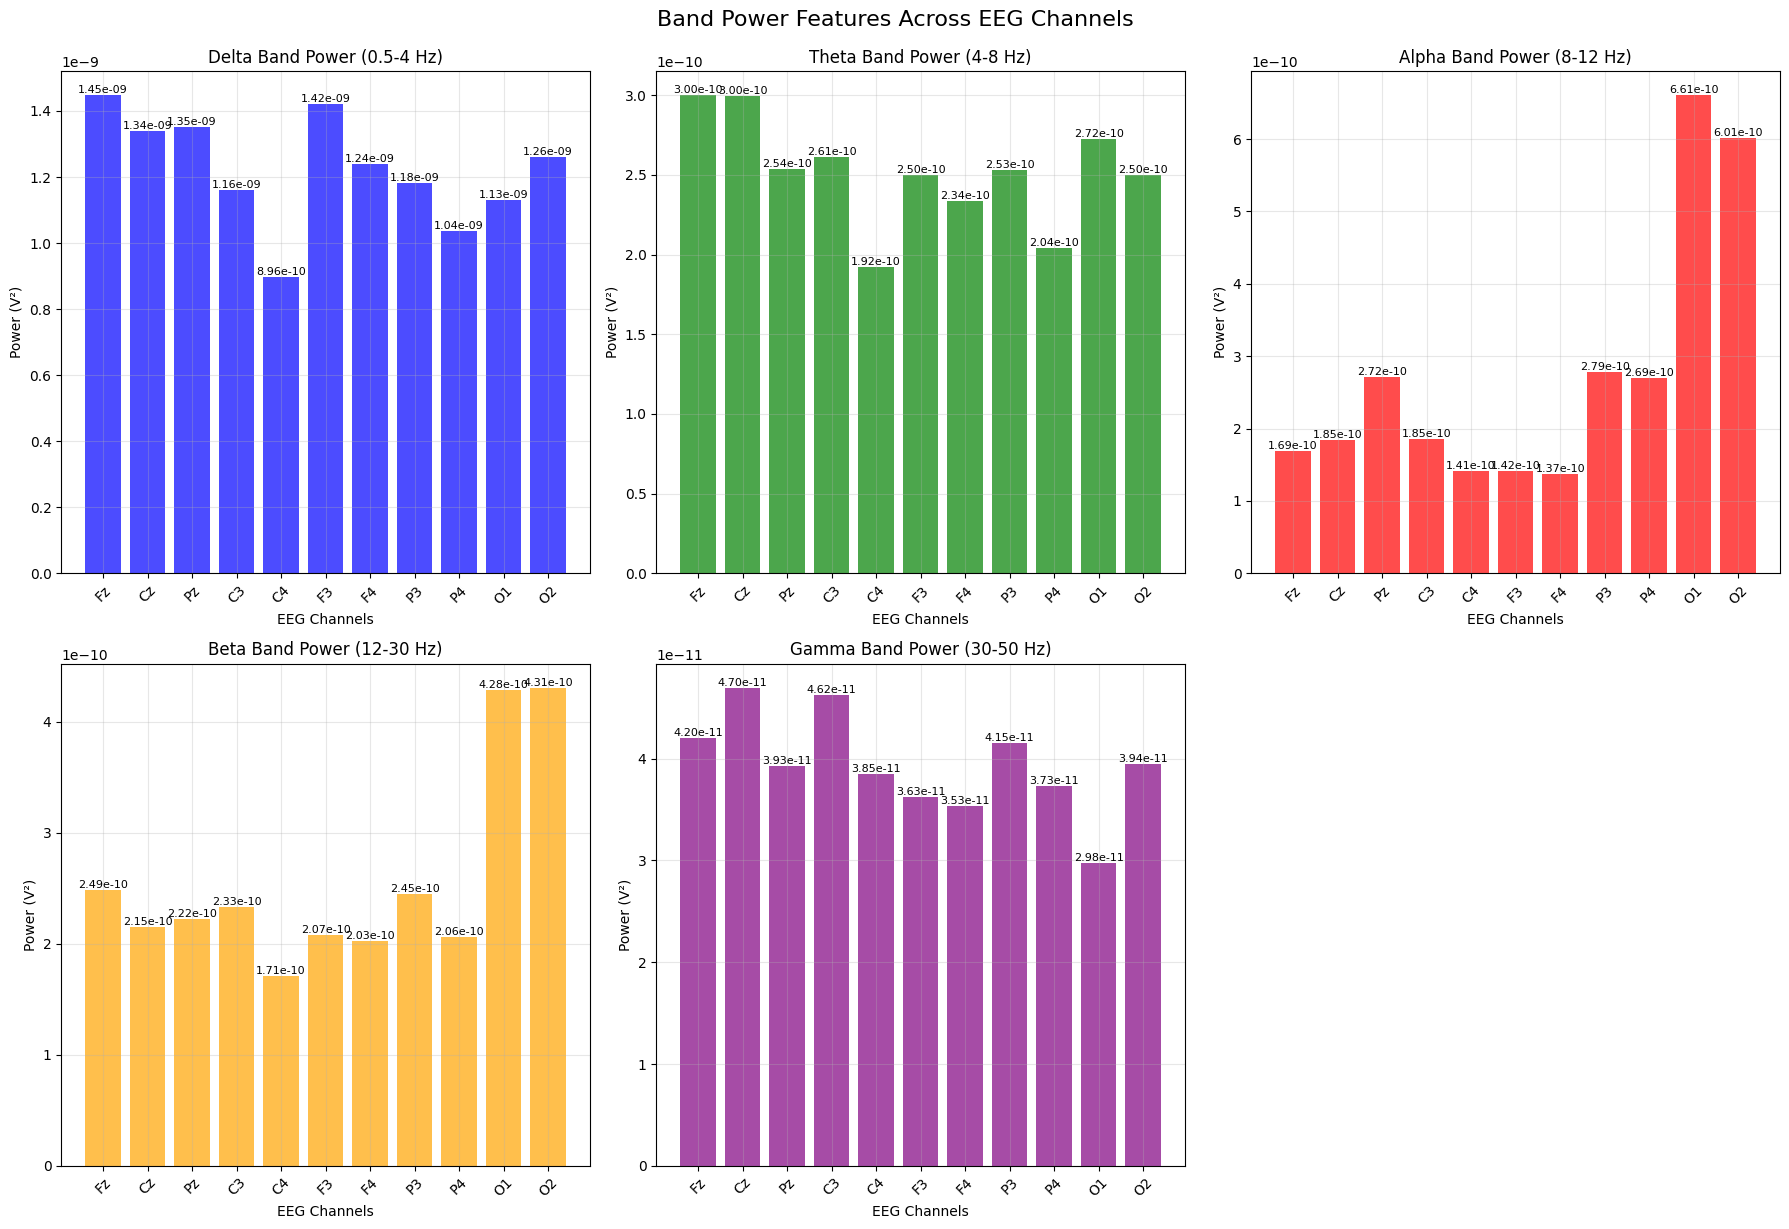

In [84]:
# Visualize band power features across channels
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (band_name, (low_freq, high_freq)) in enumerate(freq_bands.items()):
    ax = axes[i]
    
    # Get band power for all channels
    band_power_values = features['band_power'][band_name]
    
    # Create bar plot
    bars = ax.bar(range(len(channel_names_used)), band_power_values, 
                  color=colors[i], alpha=0.7)
    
    ax.set_title(f'{band_name.capitalize()} Band Power ({low_freq}-{high_freq} Hz)')
    ax.set_xlabel('EEG Channels')
    ax.set_ylabel('Power (V²)')
    ax.set_xticks(range(len(channel_names_used)))
    ax.set_xticklabels(channel_names_used, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2e}', ha='center', va='bottom', fontsize=8)

# Remove the extra subplot
axes[-1].remove()

plt.tight_layout()
plt.suptitle('Band Power Features Across EEG Channels', fontsize=16, y=1.02)
plt.show()

observations:
This plot helps you decide which channels × frequency bands are informative.

Delta (0.5–4 Hz): Fairly strong across all channels.

Theta (4–8 Hz): More evenly distributed, but slightly higher at frontal/central sites.

Alpha (8–12 Hz): Noticeable peaks at occipital channels (O1, O2) — this matches expectations, since alpha rhythm is strongest in occipital regions during rest.

Beta (12–30 Hz): Elevated at occipital (O1, O2) — could suggest task-related activity or noise/artifact depending on condition.

Gamma (30–50 Hz): Lower overall, relatively flat distribution (typical since gamma is weaker and often contaminated by muscle artifacts).


You can now identify which channels contribute the most to each frequency band.

For example, if you want to classify motor imagery tasks, you’d look carefully at C3, Cz, C4 for μ (alpha) and β power differences.

For motor imagery classification (the PhysioNet EEG motor imagery dataset you’re using), you should check if C3/C4 show differences in μ (8–12 Hz) and β (13–30 Hz) between left vs right hand tasks.


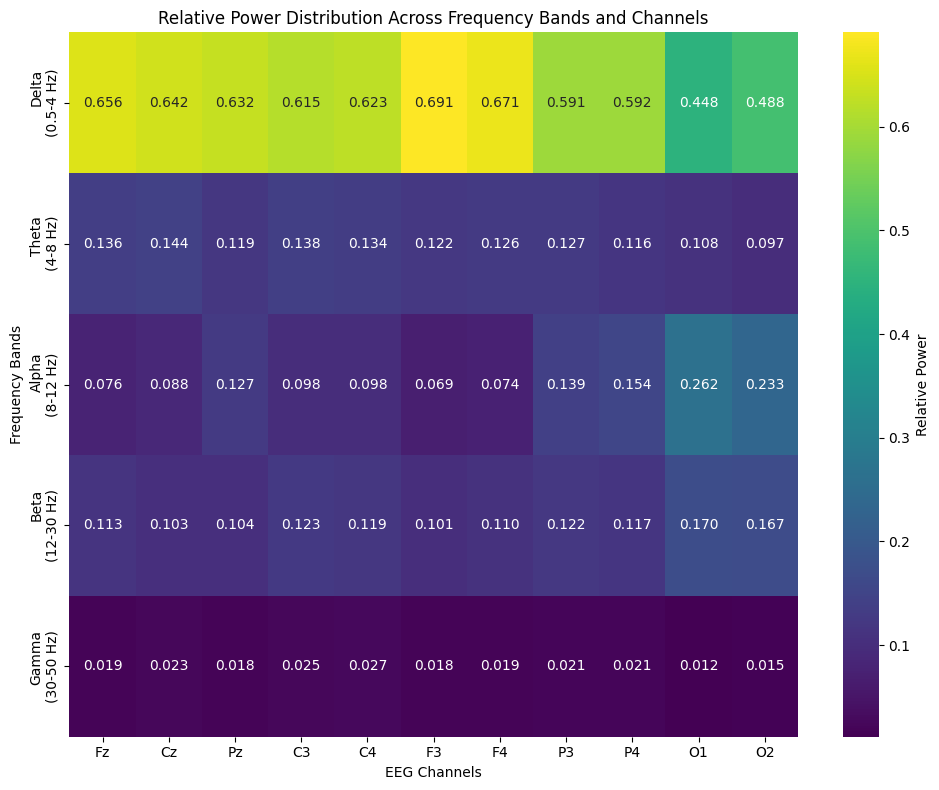

In [85]:
# Visualize relative power features as a heatmap
# Create relative power matrix
rel_power_matrix = np.zeros((len(channel_names_used), len(freq_bands)))

for i, band_name in enumerate(freq_bands.keys()):
    rel_power_matrix[:, i] = features['relative_power'][band_name]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(rel_power_matrix.T, 
            xticklabels=channel_names_used,
            yticklabels=[f'{band.capitalize()}\n({freq_bands[band][0]}-{freq_bands[band][1]} Hz)' 
                        for band in freq_bands.keys()],
            annot=True, fmt='.3f', cmap='viridis',
            cbar_kws={'label': 'Relative Power'})

plt.title('Relative Power Distribution Across Frequency Bands and Channels')
plt.xlabel('EEG Channels')
plt.ylabel('Frequency Bands')
plt.tight_layout()
plt.show()

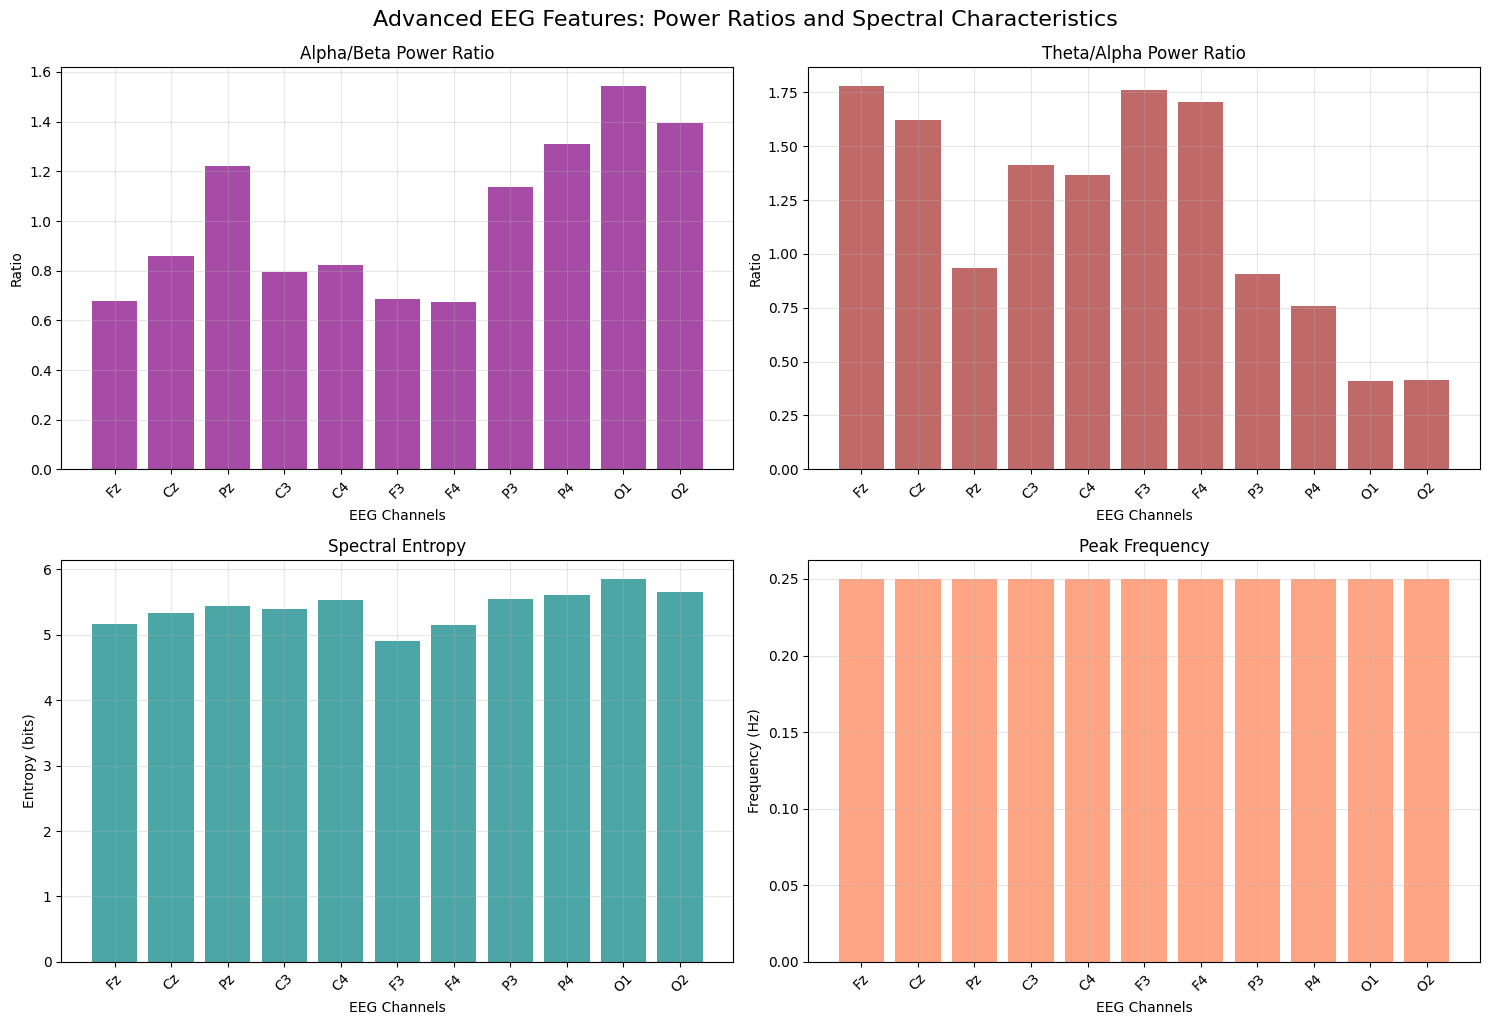

In [86]:
# Visualize power ratios and spectral features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Alpha/Beta ratio
axes[0, 0].bar(range(len(channel_names_used)), 
               features['power_ratios']['alpha_beta_ratio'],
               color='purple', alpha=0.7)
axes[0, 0].set_title('Alpha/Beta Power Ratio')
axes[0, 0].set_xlabel('EEG Channels')
axes[0, 0].set_ylabel('Ratio')
axes[0, 0].set_xticks(range(len(channel_names_used)))
axes[0, 0].set_xticklabels(channel_names_used, rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Theta/Alpha ratio
axes[0, 1].bar(range(len(channel_names_used)), 
               features['power_ratios']['theta_alpha_ratio'],
               color='brown', alpha=0.7)
axes[0, 1].set_title('Theta/Alpha Power Ratio')
axes[0, 1].set_xlabel('EEG Channels')
axes[0, 1].set_ylabel('Ratio')
axes[0, 1].set_xticks(range(len(channel_names_used)))
axes[0, 1].set_xticklabels(channel_names_used, rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Spectral entropy
axes[1, 0].bar(range(len(channel_names_used)), 
               features['spectral_entropy'],
               color='teal', alpha=0.7)
axes[1, 0].set_title('Spectral Entropy')
axes[1, 0].set_xlabel('EEG Channels')
axes[1, 0].set_ylabel('Entropy (bits)')
axes[1, 0].set_xticks(range(len(channel_names_used)))
axes[1, 0].set_xticklabels(channel_names_used, rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Peak frequency
axes[1, 1].bar(range(len(channel_names_used)), 
               features['peak_frequency'],
               color='coral', alpha=0.7)
axes[1, 1].set_title('Peak Frequency')
axes[1, 1].set_xlabel('EEG Channels')
axes[1, 1].set_ylabel('Frequency (Hz)')
axes[1, 1].set_xticks(range(len(channel_names_used)))
axes[1, 1].set_xticklabels(channel_names_used, rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Advanced EEG Features: Power Ratios and Spectral Characteristics', 
             fontsize=16, y=1.02)
plt.show()

Alpha/Beta Power Ratio (top left)

Often used as an indicator of relaxation vs. cognitive engagement.

Higher ratios (like in occipital channels O1, O2) suggest stronger alpha relative to beta → typically linked to relaxed, eyes-closed or low-cognitive-demand states.

Lower ratios (like in frontal/midline regions F3, F4, C3, C4) indicate more beta activity → associated with attention, arousal, or motor planning.

Theta/Alpha Power Ratio (top right)

Commonly used in cognitive workload and vigilance studies.

Higher ratios in frontal areas (Fz, C3, F3, F4) suggest stronger theta relative to alpha → could reflect working memory load or drowsiness.

Very low ratios in occipital channels (O1, O2) → expected, since occipital is usually alpha-dominant.

Spectral Entropy (bottom left)

Measures the irregularity or complexity of the signal’s power distribution.

Higher entropy (O1, O2, P4) → more “disordered” frequency composition, less dominance of a single band.

Lower entropy (F3, Fz) → stronger dominance of a specific rhythm, often linked to more structured brain activity.

Can distinguish between states like sleep (low entropy) vs. wakefulness (high entropy).

Peak Frequency (bottom right)

Shows the frequency where power is maximal.

Here, it looks fairly uniform across channels (~0.25 Hz in your plot, though that may be due to scaling—double-check units). Normally, this would highlight alpha peaks (~8–12 Hz in occipital), beta in motor areas, etc.

If it’s flat, it may suggest either preprocessing artifacts or averaging across conditions.


👉 What this tells you overall:

Frontal areas (Fz, F3, F4, C3, C4) show higher theta/alpha ratios → sensitive to cognitive/motor tasks.

Occipital areas (O1, O2) show high alpha/beta ratios and high entropy → strong alpha dominance (typical for visual rest states).

Parietal regions (P3, P4) sit in between, balancing cognitive and sensory processes.

These features are well-suited for feature selection in classification, since they capture both frequency content (ratios, peak) and complexity (entropy).

In [87]:
# Create a summary table of extracted features
feature_summary = pd.DataFrame({
    'Feature_Name': feature_names,
    'Feature_Value': feature_matrix.flatten()
})

# Add feature categories
feature_categories = []
for name in feature_names:
    if '_power' in name and '_rel_' not in name:
        feature_categories.append('Band Power')
    elif '_rel_power' in name:
        feature_categories.append('Relative Power')
    elif '_ratio' in name:
        feature_categories.append('Power Ratio')
    elif '_entropy' in name:
        feature_categories.append('Spectral Entropy')
    elif '_peak_frequency' in name:
        feature_categories.append('Peak Frequency')
    else:
        feature_categories.append('Other')

feature_summary['Category'] = feature_categories

# Display summary statistics
print("Feature Extraction Summary:")
print("=" * 50)
category_counts = feature_summary['Category'].value_counts()
for category, count in category_counts.items():
    print(f"{category}: {count} features")

print(f"\nTotal features extracted: {len(feature_names)}")
print(f"Feature matrix shape: {feature_matrix.shape}")

# Display first few features from each category
print("\nSample features by category:")
for category in category_counts.index:
    sample_features = feature_summary[feature_summary['Category'] == category].head(3)
    print(f"\n{category}:")
    for _, row in sample_features.iterrows():
        print(f"  {row['Feature_Name']}: {row['Feature_Value']:.6f}")

Feature Extraction Summary:
Band Power: 55 features
Relative Power: 55 features
Power Ratio: 22 features
Spectral Entropy: 11 features
Peak Frequency: 11 features

Total features extracted: 154
Feature matrix shape: (1, 154)

Sample features by category:

Band Power:
  Fz_delta_power: 0.000000
  Cz_delta_power: 0.000000
  Pz_delta_power: 0.000000

Relative Power:
  Fz_delta_rel_power: 0.655897
  Cz_delta_rel_power: 0.642307
  Pz_delta_rel_power: 0.631815

Power Ratio:
  Fz_alpha_beta_ratio: 0.678423
  Cz_alpha_beta_ratio: 0.857764
  Pz_alpha_beta_ratio: 1.222377

Spectral Entropy:
  Fz_spectral_entropy: 5.164968
  Cz_spectral_entropy: 5.341198
  Pz_spectral_entropy: 5.435287

Peak Frequency:
  Fz_peak_frequency: 0.250000
  Cz_peak_frequency: 0.250000
  Pz_peak_frequency: 0.250000
